In [1]:
import sys
sys.path.append("/home/mdzik/rysy/TCLB_tools/Python")


In [2]:
!pip install --user display_xml

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from display_xml import XML
import CLB.CLBXMLWriter as CLBXML   

ModuleNotFoundError: No module named 'display_xml'

In [ ]:
import os
import subprocess
TCLB_shell_preamble = '/home/mdzik/rysy/TCLB/CLB/auto_porous_media_d3q19_TRT_GinzburgEqOrd1/main'
def RunCase(filename):
    cwd = os.getcwd()
    ret = subprocess.run("singularity exec --bind /lu/tetyda/home/mdzik --nv ~/rysy/TCLB_docker/.local/tclb_buildkit__ubuntu_2004_cuda11_latest mpirun -np 1  ~/rysy/TCLB/CLB/auto_porous_media_d3q19_TRT_GinzburgEqOrd1/main " + filename, shell=True, check=False, capture_output=True)    
    print(ret.stdout.decode('utf-8'))
    print(ret.stderr.decode('utf-8'))


# Poiseuille flow, no permability

In [4]:
# Prepare input


Viscosity = 1./6.
Length = 21
Gravity = 0.001

CLBc = CLBXML.CLBConfigWriter( )


CLBc.addGeomParam('nx', 6)
CLBc.addGeomParam('ny', Length)
CLBc.addGeomParam('nz', 6)


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWall()
CLBc.addBox(dy=-1)
CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 3./8.,
        "LinearReactionRate": 0.0,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 1./6.,
        "Init_PHI": 1,
        
}

CLBc.addModelParams(params)

CLBc.addRunR(eval=\
f"""
    Solver$Fields$InitialPorosity[] = 1;   
    Solver$Fields$Porosity[] = 1;   
    Solver$Fields$InitialPermability[] = 1E8
    Solver$Fields$Permability[] = 1E8
""")


CLBc.addHDF5()
time = 10000
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('PouseiFlow.xml')


RunCase(os.getcwd()+'/PouseiFlow.xml')



MPMD: TCLB: local:0/1 work:0/1 ---  connected to:
[  ]    #### : -------------------------------------------------------------------------
[  ]    #### : -  CLB version:  v6.0-beta-1827-gc30baf50                               -
[  ]    #### : -        Model: auto_porous_media_d3q19_TRT_GinzburgEqOrd1                               -
[  ]    #### : -------------------------------------------------------------------------
[  ]    #### : Setting output path to: PouseiFlow
[  ]    ---- : Discarding 1 comments
[ 0]    ---- : Selecting device 0/1
[ 0] warning ! No "Units" element in config file
[  ]    ==== : Mesh size in config file: 6x21x6
[  ]    ---- : Global lattice size: 6x21x6
[  ]    ==== : Max region size: 4032. Mesh size 4032. Overhead:  0%
[  ]    ---- : Local lattice size: 32x21x6
[  ]    ---- :   Threads  |      Action
[  ]    ---- :    32x16   | Primal , NoGlobals , InitFromExternal
[  ]    ---- :    32x16   | Tangent , NoGlobals , InitFromExternal
[  ]    ---- :    32x16   | Op

0
1000
2000
3000
4000
5000
6000
7000
8000


<Figure size 432x288 with 0 Axes>

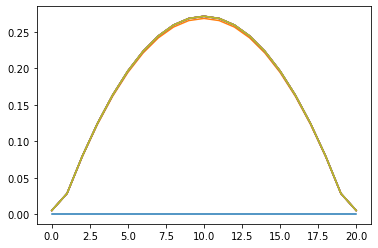

<Figure size 432x288 with 0 Axes>

In [5]:

ut = list()
for i in range(0,time,int(time/10))[:-1]:
    print(i)
    f = h5py.File('./output/PouseiFlow_HDF5_%08d.h5'%i, mode='r')    
    plt.plot(f['U'][0,:,0,0])
    ut.append(np.absolute(f['U'][0,0,0,0]))

    
plt.figure()


# Poiseuille, inlet/outlet BC

MPMD: TCLB: local:0/1 work:0/1 ---  connected to:
[  ]    #### : -------------------------------------------------------------------------
[  ]    #### : -  CLB version:  v6.0-beta-1827-gc30baf50                               -
[  ]    #### : -        Model: auto_porous_media_d3q19_TRT_GinzburgEqOrd1                               -
[  ]    #### : -------------------------------------------------------------------------
[  ]    #### : Setting output path to: PouseiFlow
[  ]    ---- : Discarding 1 comments
[ 0]    ---- : Selecting device 0/1
[ 0] warning ! No "Units" element in config file
[  ]    ==== : Mesh size in config file: 160x32x32
[  ]    ---- : Global lattice size: 160x32x32
[  ]    ==== : Max region size: 163840. Mesh size 163840. Overhead:  0%
[  ]    ---- : Local lattice size: 160x32x32
[  ]    ---- :   Threads  |      Action
[  ]    ---- :    32x16   | Primal , NoGlobals , InitFromExternal
[  ]    ---- :    32x16   | Tangent , NoGlobals , InitFromExternal
[  ]    ---- :    

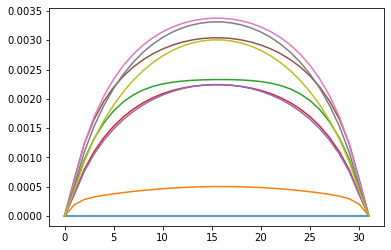

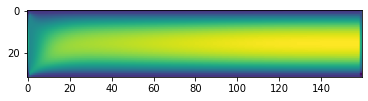

In [49]:
# Prepare input


Viscosity = 1./6.
Length = 32
Gravity = 0.000

CLBc = CLBXML.CLBConfigWriter( )


CLBc.addGeomParam('nx', 5*Length)
CLBc.addGeomParam('ny', Length)
CLBc.addGeomParam('nz', Length)


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()



CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)

#CLBc.addWall()
#CLBc.addBox(dx=-1)



CLBc.addWall()
CLBc.addBox(dy=-1)
CLBc.addBox(ny=1)
CLBc.addBox(dz=-1)
CLBc.addBox(nz=1)




params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 3./8.,
        "LinearReactionRate": 0.0,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 1./6.,
        "Init_PHI": 1,
        
}

CLBc.addModelParams(params)

CLBc.addModelParam("Velocity", 0.1, zone='inlet')


CLBc.addRunR(eval=\
f"""
    Solver$Fields$InitialPorosity[] = 1;   
    Solver$Fields$Porosity[] = 1;   
    Solver$Fields$InitialPermability[] = 1E8
    Solver$Fields$Permability[] = 1E8
""")


CLBc.addHDF5()
time = 1000
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('PouseiFlow.xml')


! rm -rf ./output/* 

RunCase(os.getcwd()+'/PouseiFlow.xml')



ut = list()
for i in range(0,time,int(time/10))[:-1]:
    print(i)
    f = h5py.File('./output/PouseiFlow_HDF5_%08d.h5'%i, mode='r')    
    plt.plot(f['U'][0,:,2*Length,0])
    ut.append(np.absolute(f['U'][0,0,0,0]))

    
plt.figure()


plt.imshow(f['U'][Length/2,:,:,0])

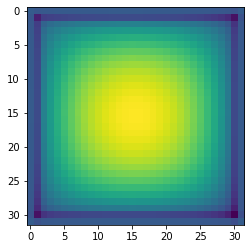

In [51]:
plt.imshow(f['U'][:,:,0,0])

# Uniform permability, periodic domain

MPMD: TCLB: local:0/1 work:0/1 ---  connected to:
[  ]    #### : -------------------------------------------------------------------------
[  ]    #### : -  CLB version:  v6.0-beta-1827-gc30baf50                               -
[  ]    #### : -        Model: auto_porous_media_d3q19_TRT_GinzburgEqOrd1                               -
[  ]    #### : -------------------------------------------------------------------------
[  ]    #### : Setting output path to: Pseudo1DFlow
[  ]    ---- : Discarding 1 comments
[ 0]    ---- : Selecting device 0/1
[ 0] warning ! No "Units" element in config file
[  ]    ==== : Mesh size in config file: 1x50x6
[  ]    ---- : Global lattice size: 1x50x6
[  ]    ==== : Max region size: 9600. Mesh size 9600. Overhead:  0%
[  ]    ---- : Local lattice size: 32x50x6
[  ]    ---- :   Threads  |      Action
[  ]    ---- :    32x16   | Primal , NoGlobals , InitFromExternal
[  ]    ---- :    32x16   | Tangent , NoGlobals , InitFromExternal
[  ]    ---- :    32x16   | 

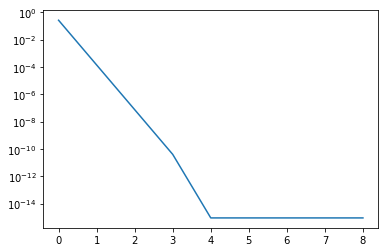

In [6]:
# Prepare input

UniformPermability = 0.03
Viscosity = 1./6.
Length = 50
Gravity = 0.001

Porosity = np.ones((Length,1)) 
Permability = np.ones_like(Porosity) * UniformPermability


init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 1D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[1])
CLBc.addGeomParam('ny', dim[0])
CLBc.addGeomParam('nz', 6)


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

# CLBc.addWDirichlet(name='inlet')
# CLBc.addBox(nx=1)

# CLBc.addENeuman()
# CLBc.addBox(dx=-2)
# CLBc.addWall()
# CLBc.addBox(dx=-1)
# CLBc.addBox(dy=-1)
# CLBc.addBox(ny=1)

params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 3./8.,
        "LinearReactionRate": 0.0,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 1./6.,
        "Init_PHI": 1,
        
}

CLBc.addModelParams(params)

CLBc.addRunR(eval=\
f"""
    con <- file("porosity.bin", "rb")
    Porosity <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")


CLBc.addHDF5()
time = 100
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('Pseudo1DFlow.xml')
! rm -rf ./output/* 

RunCase(os.getcwd()+'/Pseudo1DFlow.xml')



ut = list()
for i in range(0,time,int(time/10))[:-1]:
    print(i)
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i, mode='r')    
    ut.append(np.absolute(f['U'][0,0,0,0] / (UniformPermability * Gravity / Viscosity) - 1))


plt.semilogy(ut)


# Non-uniform 1D permability assisted by linear pressure gradient

(32, 32, 224)


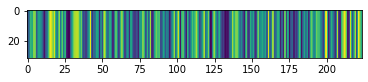

(32, 32, 224)
MPMD: TCLB: local:0/1 work:0/1 ---  connected to:
[  ]    #### : -------------------------------------------------------------------------
[  ]    #### : -  CLB version:  v6.0-beta-1827-gc30baf50                               -
[  ]    #### : -        Model: auto_porous_media_d3q19_TRT_GinzburgEqOrd1                               -
[  ]    #### : -------------------------------------------------------------------------
[  ]    #### : Setting output path to: Pseudo1DFlow
[  ]    ---- : Discarding 1 comments
[ 0]    ---- : Selecting device 0/1
[ 0] warning ! No "Units" element in config file
[  ]    ==== : Mesh size in config file: 224x32x32
[  ]    ---- : Global lattice size: 224x32x32
[  ]    ==== : Max region size: 229376. Mesh size 229376. Overhead:  0%
[  ]    ---- : Local lattice size: 224x32x32
[  ]    ---- :   Threads  |      Action
[  ]    ---- :    32x16   | Primal , NoGlobals , InitFromExternal
[  ]    ---- :    32x16   | Tangent , NoGlobals , InitFromExternal
[ 

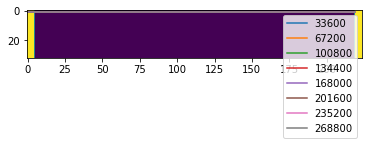

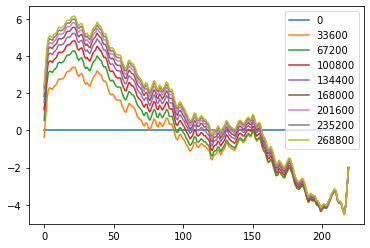

In [132]:
Viscosity = 1./6.
Length = 224
Width = 32
Depth= 32
Velocity = 0.01


Permability = (np.random.rand(Length).reshape([1,Length])*0.05) + 0.05
Permability = np.repeat(np.repeat(Permability, Width,axis=0).T,Depth).reshape(Length,Width,Depth).T
Permability[:,:,:5] = 1E10
Permability[:,:,-5:] = 1E10

print(Permability.shape)
plt.imshow(Permability[1,:,:])


Gravity = np.sum(1./Permability[0,0,:])*Velocity*Viscosity / (Length)

#x = np.linspace(0,2*np.pi,Length)
#Permability = (np.sin(x)+1.1)*0.9
#Permability = np.ones((Width,Length)) * 1E6

#Permability[:,int(Length/3):int(2*Length/3)] = 0.1

Porosity = np.ones_like(Permability) 


init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 1D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[2])
CLBc.addGeomParam('ny', dim[1])
CLBc.addGeomParam('nz', dim[0])


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)


#CLBc.addWall()
#CLBc.addBox(nx=1)
#CLBc.addBox(dy=-1)
#CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 4./8.,
        "LinearReactionRate": 0.0,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 1./6.,
        "Init_PHI": 1,
        
}

CLBc.addModelParams(params)
CLBc.addModelParam("Velocity", Velocity, zone='inlet')

CLBc.addRunR(eval=\
f"""
    dims = dim( Solver$Fields$InitialPermability) 

    con <- file("porosity.bin", "rb")
    Porosity <- array( readBin(con, "numeric", prod({dim[0]*dim[1]*dim[2]})), c({dim[2]},{dim[1]},{dim[0]}))#[(Solver$Geometry$dx+1):(Solver$Geometry$dx+dims[1]),(Solver$Geometry$dy+1):(Solver$Geometry$dy+dims[2]),(Solver$Geometry$dz+1):(Solver$Geometry$dz+dims[3])]
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- array( readBin(con, "numeric", prod({dim[0]*dim[1]*dim[2]})), c({dim[2]},{dim[1]},{dim[0]}))#[(Solver$Geometry$dx+1):(Solver$Geometry$dx+dims[1]),(Solver$Geometry$dy+1):(Solver$Geometry$dy+dims[2]),(Solver$Geometry$dz+1):(Solver$Geometry$dz+dims[3])]
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")


CLBc.addHDF5()
time = 15 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('Pseudo1DFlow.xml')


! rm -rf ./output/* 
RunCase(os.getcwd()+'/Pseudo1DFlow.xml')


ut = list()
for i in range(0,time,int(time/10))[1:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i, 'r')    
    plt.plot(f['U'][0,0,2:-2,0]/Velocity, label=i)
    ut.append(np.absolute(f['U'][0,0,0,0]))
plt.legend()
#plt.plot( np.ones(Length)*(np.average(Permability) * Gravity / Viscosity) , 'r--', lw=2    )
    
plt.figure()
#plt.semilogy(ut)
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i, mode='r')    
    plt.plot(f['P'][0,2,2:-2] / Gravity, label=i)
    
    
plt.legend()

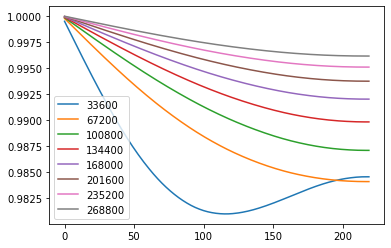

In [142]:
ut = list()
for i in range(0,time,int(time/10))[1:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i, 'r')    
    plt.plot(f['U'][0,0,2:-2,0]/Velocity, label=i)
    ut.append(np.absolute(f['U'][0,0,0,0]))
plt.legend()

Text(0, 0.5, 'Pressure gradient')

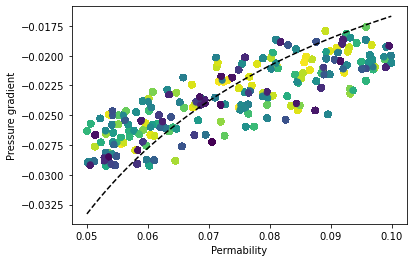

In [154]:
x = np.arange(f['P'].shape[2]-10)
P = f['P'][:,:,5:-5]
dP = np.gradient(P,axis=2) - Gravity
#plt.plot(x,)
#plt.twinx()
plt.scatter(f['Permability'][:,:,5:-5],dP, c=P)

Phi = np.linspace(np.min(f['Permability']), np.max(f['Permability'][:,:,5:-5]))

plt.plot(Phi,-Velocity*Viscosity/Phi , 'k--')
plt.xlabel('Permability')
plt.ylabel('Pressure gradient')

0
33600
67200
100800
134400
168000
201600
235200
268800
302400


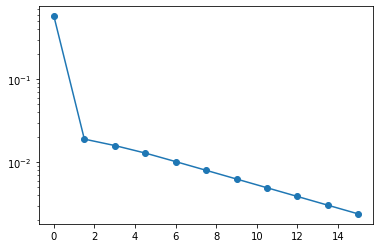

In [134]:
ut = list()
ts = list()
for i in range(0,time,int(time/10))[:]:
    print(i)
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')    
    ut.append(np.max(np.absolute(f['U'][0,2:-2,2:-2,0]-Velocity))/Velocity)
    ts.append(i)
i = time

f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')    
ut.append(np.max(np.absolute(f['U'][0,2:-2,2:-2,0]-Velocity))/Velocity)
ts.append(i)
plt.semilogy(Velocity/Length*np.array(ts),ut, 'o-')

# Non-uniform 1D permability assisted by linear pressure gradient with concentration, without reaction

(32, 32, 224)
MPMD: TCLB: local:0/1 work:0/1 ---  connected to:
[  ]    #### : -------------------------------------------------------------------------
[  ]    #### : -  CLB version:  v6.0-beta-1827-gc30baf50                               -
[  ]    #### : -        Model: auto_porous_media_d3q19_TRT_GinzburgEqOrd1                               -
[  ]    #### : -------------------------------------------------------------------------
[  ]    #### : Setting output path to: Pseudo1DFlow
[  ]    ---- : Discarding 1 comments
[ 0]    ---- : Selecting device 0/1
[ 0] warning ! No "Units" element in config file
[  ]    ==== : Mesh size in config file: 224x32x32
[  ]    ---- : Global lattice size: 224x32x32
[  ]    ==== : Max region size: 229376. Mesh size 229376. Overhead:  0%
[  ]    ---- : Local lattice size: 224x32x32
[  ]    ---- :   Threads  |      Action
[  ]    ---- :    32x16   | Primal , NoGlobals , InitFromExternal
[  ]    ---- :    32x16   | Tangent , NoGlobals , InitFromExternal
[ 

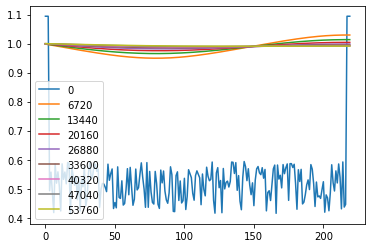

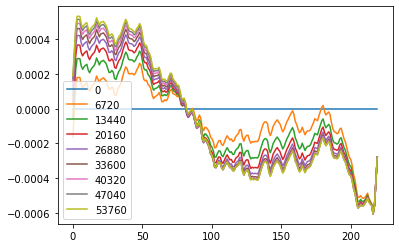

In [161]:
Viscosity = 1./6.
Length = 224
Width = 32
Depth= 32
Velocity = 0.01


Permability = (np.random.rand(Length).reshape([1,Length])*0.05) + 0.05
Permability = np.repeat(np.repeat(Permability, Width,axis=0).T,Depth).reshape(Length,Width,Depth).T
Permability[:,:,:5] = 1E10
Permability[:,:,-5:] = 1E10

print(Permability.shape)
#plt.imshow(Permability[1,:,:])


Gravity = np.sum(1./Permability[0,0,:])*Velocity*Viscosity / (Length)

#x = np.linspace(0,2*np.pi,Length)
#Permability = (np.sin(x)+1.1)*0.9
#Permability = np.ones((Width,Length)) * 1E6

#Permability[:,int(Length/3):int(2*Length/3)] = 0.1

Porosity = np.ones_like(Permability) 


init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 1D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[2])
CLBc.addGeomParam('ny', dim[1])
CLBc.addGeomParam('nz', dim[0])


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)


#CLBc.addWall()
#CLBc.addBox(nx=1)
#CLBc.addBox(dy=-1)
#CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 4./8.,
        "LinearReactionRate": 0.0,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 1./6.,
        "Init_PHI": 0,
        
}

CLBc.addModelParams(params)
CLBc.addModelParam("Velocity", Velocity, zone='inlet')
CLBc.addModelParam("Init_PHI", 1, zone='inlet')


CLBc.addRunR(eval=\
f"""
    dims = dim( Solver$Fields$InitialPermability) 

    con <- file("porosity.bin", "rb")
    Porosity <- array( readBin(con, "numeric", prod({dim[0]*dim[1]*dim[2]})), c({dim[2]},{dim[1]},{dim[0]}))#[(Solver$Geometry$dx+1):(Solver$Geometry$dx+dims[1]),(Solver$Geometry$dy+1):(Solver$Geometry$dy+dims[2]),(Solver$Geometry$dz+1):(Solver$Geometry$dz+dims[3])]
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- array( readBin(con, "numeric", prod({dim[0]*dim[1]*dim[2]})), c({dim[2]},{dim[1]},{dim[0]}))#[(Solver$Geometry$dx+1):(Solver$Geometry$dx+dims[1]),(Solver$Geometry$dy+1):(Solver$Geometry$dy+dims[2]),(Solver$Geometry$dz+1):(Solver$Geometry$dz+dims[3])]
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")



CLBc.addHDF5()
time = 3 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('Pseudo1DFlow.xml')



! rm -rf ./output/* 
RunCase(os.getcwd()+'/Pseudo1DFlow.xml')


ut = list()
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')    
    plt.plot(f['U'][0,2,2:-2,0]/Velocity, label=i)
    ut.append(np.absolute(f['U'][0,0,0,0]))
plt.legend()
#plt.plot( np.ones(Length)*(np.average(Permability) * Gravity / Viscosity) , 'r--', lw=2    )
    
plt.figure()
#plt.semilogy(ut)
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')    
    plt.plot(f['P'][0,2,2:-2] / (np.sum(1./Permability[0,:])*Velocity*Viscosity), label=i)
    
    
plt.legend()

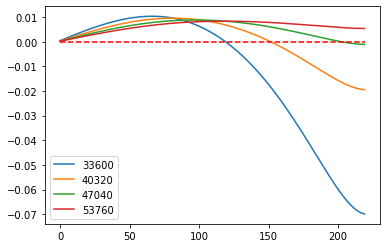

In [168]:
    
plt.figure()
#plt.semilogy(ut)
for i in range(0,time,int(time/10))[5:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')    
    plt.plot(f['PHI'][0,2,2:-2]-1 , label=i)

plt.plot( np.zeros_like(f['PHI'][0,2,2:-2]), 'r--')    
    
    
plt.legend()

# Non-uniform 1D permability assisted by linear pressure gradient with concentration, with linear reaction

In [160]:
LinearReactionRate = 0.01
Viscosity = 1./6.
Length = 224
Width = 32
Depth= 32
Velocity = 0.01


Permability = (np.random.rand(Length).reshape([1,Length])*0.05) + 0.05
Permability = np.repeat(np.repeat(Permability, Width,axis=0).T,Depth).reshape(Length,Width,Depth).T
Permability[:,:,:5] = 1E10
Permability[:,:,-5:] = 1E10

print(Permability.shape)
#plt.imshow(Permability[1,:,:])


Gravity = np.sum(1./Permability[0,0,:])*Velocity*Viscosity / (Length)

#x = np.linspace(0,2*np.pi,Length)
#Permability = (np.sin(x)+1.1)*0.9
#Permability = np.ones((Width,Length)) * 1E6

#Permability[:,int(Length/3):int(2*Length/3)] = 0.1

Porosity = (np.random.rand(Length).reshape([1,Length])*0.4) + 0.2
Porosity = np.repeat(np.repeat(Porosity, Width,axis=0).T,Depth).reshape(Length,Width,Depth).T

init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 1D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[2])
CLBc.addGeomParam('ny', dim[1])
CLBc.addGeomParam('nz', dim[0])


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)


#CLBc.addWall()
#CLBc.addBox(nx=1)
#CLBc.addBox(dy=-1)
#CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 4./8.,
        "LinearReactionRate": LinearReactionRate,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 0.001,
        "Init_PHI": 0,
        
}

CLBc.addModelParams(params)
CLBc.addModelParam("Velocity", Velocity, zone='inlet')
CLBc.addModelParam("Init_PHI", 0, zone='inlet')


CLBc.addRunR(eval=\
f"""
    dims = dim( Solver$Fields$InitialPermability) 

    con <- file("porosity.bin", "rb")
    Porosity <- array( readBin(con, "numeric", prod({dim[0]*dim[1]*dim[2]})), c({dim[2]},{dim[1]},{dim[0]}))#[(Solver$Geometry$dx+1):(Solver$Geometry$dx+dims[1]),(Solver$Geometry$dy+1):(Solver$Geometry$dy+dims[2]),(Solver$Geometry$dz+1):(Solver$Geometry$dz+dims[3])]
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- array( readBin(con, "numeric", prod({dim[0]*dim[1]*dim[2]})), c({dim[2]},{dim[1]},{dim[0]}))#[(Solver$Geometry$dx+1):(Solver$Geometry$dx+dims[1]),(Solver$Geometry$dy+1):(Solver$Geometry$dy+dims[2]),(Solver$Geometry$dz+1):(Solver$Geometry$dz+dims[3])]
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")


CLBc.addHDF5()
time = 5 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('Pseudo1DFlow.xml')


! rm -rf ./output/* 
RunCase(os.getcwd()+'/Pseudo1DFlow.xml')


ut = list()
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')    
    plt.plot(f['U'][0,2,2:-2,0]/Velocity, label=i)
    ut.append(np.absolute(f['U'][0,0,0,0]))
plt.legend()
#plt.plot( np.ones(Length)*(np.average(Permability) * Gravity / Viscosity) , 'r--', lw=2    )
    
plt.figure()
#plt.semilogy(ut)
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')    
    plt.plot(f['P'][0,2,2:-2] / (np.sum(1./Permability[0,:])*Velocity*Viscosity), label=i)
    
    
plt.legend()


plt.figure()


from scipy.integrate import odeint

def dydt(y,t,*gamma):
    return gamma[0]*(1-y)
   
y0 = f['PHI'][0,2,2]

t = np.linspace(0,40)
sol = odeint(dydt, y0, t, args=(LinearReactionRate/Velocity,0))


for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')    
    plt.plot(f['PHI'][0,2,2:-2], label=i)
    
plt.plot(t,sol, 'k--', lw=1.5)

plt.legend()

(32, 32, 224)


KeyboardInterrupt: 

# Uniform 1D permability assisted by linear pressure gradient with concentration, with linear reaction and dissolituin

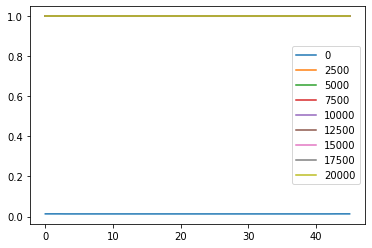

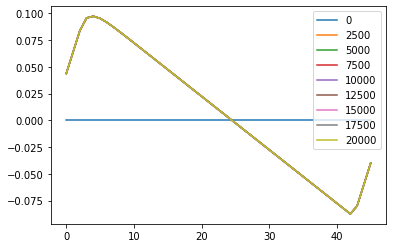

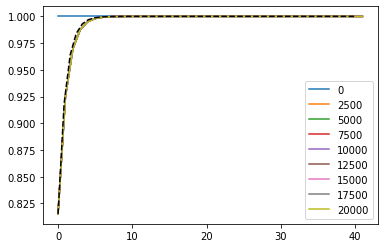

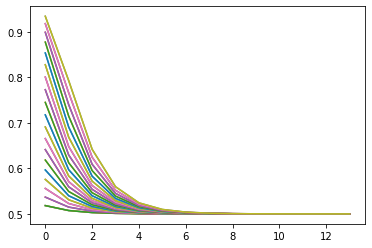

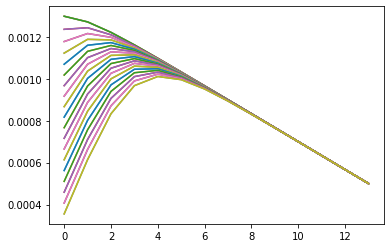

In [693]:
# Prepare input


Viscosity = 1./6.
Length = 50
Width = 3
Velocity = 0.01
LinearReactionRate = 0.01
KarmanKozenyCoefficient = 10
SolidFluidReactionRate = 10
Porosity = ((np.random.rand(Length, 1).reshape([Length, 1])-0.5)*0.) + 0.5
Porosity = np.repeat(Porosity, Width,axis=1).T

Porosity[:,:5] = 1
Porosity[:,-5:] = 1
Permability = KarmanKozenyCoefficient*Porosity**3/((1-Porosity)**2 + 1E-8)

Gravity = np.sum(1./Permability[0,:])*Velocity*Viscosity / (Length)

init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 1D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[1])
CLBc.addGeomParam('ny', dim[0])
CLBc.addGeomParam('nz', 2)


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)


#CLBc.addWall()
#CLBc.addBox(nx=1)
#CLBc.addBox(dy=-1)
#CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 4./8.,
        "LinearReactionRate": LinearReactionRate,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 0.001,
        "Init_PHI": 1,
        "ImpliciteReactionIntegration": 1,
        "KarmanKozenyCoefficient": KarmanKozenyCoefficient

}

CLBc.addModelParams(params)
CLBc.addModelParam("Velocity", Velocity, zone='inlet')
CLBc.addModelParam("Init_PHI", 0, zone='inlet')


CLBc.addRunR(eval=\
f"""
    con <- file("porosity.bin", "rb")
    Porosity <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")


CLBc.addHDF5()
time = 5 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)


CLBc.addModelParam("SolidFluidReactionsRate", SolidFluidReactionRate)
makroIterations = int(20)
time1 = makroIterations * 2 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time1)
CLBc.addHDF5(Iterations=time1/(makroIterations*2), parent=solve)
CLBc.addRunR(eval=\
f"""
    #Solver$Fields$InitialPorosity[] = Solver$Fields$Porosity[];    
    #Solver$Fields$InitialPermability[] = Solver$Fields$Permability[];
    Solver$Actions$GlobasPorosityDissolutionTimeStepAction()
""", Iterations = time1/makroIterations, parent=solve)



CLBc.write('Pseudo1DFlow.xml')


! rm -rf ./output/* && tclb auto_porous_media_d3q19_TRT_GinzburgEqOrd1 Pseudo1DFlow.xml > /dev/null

ut = list()
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['U'][0,2,2:-2,0]/Velocity, label=i)
    ut.append(np.absolute(f['U'][0,0,0,0]))
plt.legend()
#plt.plot( np.ones(Length)*(np.average(Permability) * Gravity / Viscosity) , 'r--', lw=2    )
    
plt.figure()
#plt.semilogy(ut)
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['P'][0,2,2:-2] / (np.sum(1./Permability[0,:])*Velocity*Viscosity), label=i)
    
    
plt.legend()


plt.figure()


from scipy.integrate import odeint

def dydt(y,t,*gamma):
    return gamma[0]*(1-y)
   
y0 = f['PHI'][0,2,6]

t = np.linspace(0,40)
sol = odeint(dydt, y0, t, args=(LinearReactionRate/Velocity,0))


for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['PHI'][0,2,6:-2], label=i)
    
plt.plot(t,sol, 'k--', lw=1.5)

plt.legend()

plt.figure()
for i in time+np.arange(0,time1,int(time1/(makroIterations*2)))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['Porosity'][0,2,6:20], label=i)
    
plt.figure()
for i in time+np.arange(0,time1,int(time1/(makroIterations*2)))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['P'][0,2,6:20], label=i)    


# Non-uniform 2D permability assisted by linear pressure gradient with concentration, with linear reaction and dissolution

Pe = 32.0
Da = 327680.0


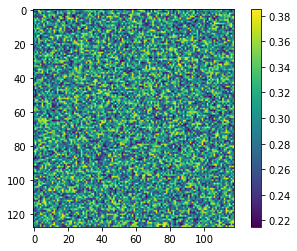

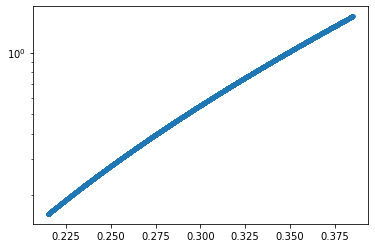

0.008698580990568097


In [68]:
# Prepare input

Viscosity = 1./6.
Length = 128
Width = 128
Velocity = 0.025
LinearReactionRate = 0.1
KarmanKozenyCoefficient = 10
SolidFluidReactionRate = 10
Diffusivity = 0.005

print(f'Pe = {Length*Velocity/LinearReactionRate}')
print(f'Da = {Length**2*LinearReactionRate/Diffusivity}')

Porosity = ((np.random.rand(Length, Width).reshape([Length, Width])-0.5)*0.17) + 0.3
#Porosity = np.repeat(Porosity, Width,axis=1).T
Porosity[:,:5] = 1
Porosity[:,-5:] = 1
Permability = KarmanKozenyCoefficient*Porosity**3/((1-Porosity)**2 + 1E-8)

plt.imshow(Porosity[:,5:-5])
plt.colorbar()
plt.figure()
plt.semilogy(Porosity[:,5:-5].ravel(), Permability[:,5:-5].ravel(), '.')
plt.show()

Gravity = np.sum(1./Permability[0,:])*Velocity*Viscosity / (Length)

print(Gravity)
init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 2D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[1])
CLBc.addGeomParam('ny', dim[0])
CLBc.addGeomParam('nz', 4)


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)


#CLBc.addWall()
#CLBc.addBox(nx=1)
#CLBc.addBox(dy=-1)
#CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 4./8.,
        "LinearReactionRate": LinearReactionRate,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": Diffusivity,
        "Init_PHI": 1,
        "ImpliciteReactionIntegration": 1,
        "KarmanKozenyCoefficient": KarmanKozenyCoefficient
}

CLBc.addModelParams(params)
CLBc.addModelParam("Velocity", Velocity, zone='inlet')
CLBc.addModelParam("Init_PHI", 0, zone='inlet')


CLBc.addRunR(eval=\
f"""
    con <- file("porosity.bin", "rb")
    Porosity <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")



CLBc.addHDF5()
time = 5 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)


CLBc.addModelParam("SolidFluidReactionsRate", SolidFluidReactionRate)
makroIterations = int(1000)
time1 = makroIterations * int(Length/Velocity) / 2
solve = CLBc.addSolve(iterations=time1)
CLBc.addHDF5(Iterations=time1/(makroIterations), parent=solve)
CLBc.addRunR(eval=\
f"""
    #Solver$Fields$InitialPorosity[] = Solver$Fields$Porosity[];    
    #Solver$Fields$InitialPermability[] = Solver$Fields$Permability[];
    Solver$Actions$GlobasPorosityDissolutionTimeStepAction()
""", Iterations = time1/makroIterations, parent=solve)


CLBc.write('Pseudo1DFlow.xml')

#! rm -rf ./output/* && tclb auto_porous_media_d3q19_TRT_GinzburgEqOrd1 Pseudo1DFlow.xml > /dev/null && echo 'DONE'


0
2560
5120
7680
10240
12800
15360
17920
20480


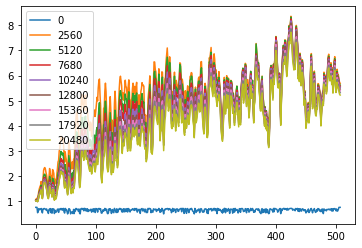

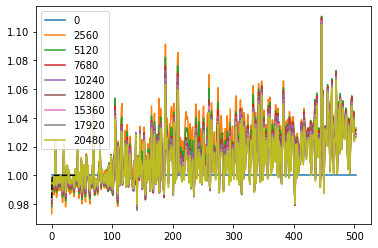

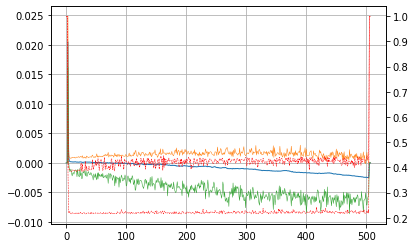

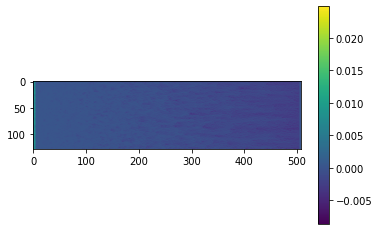

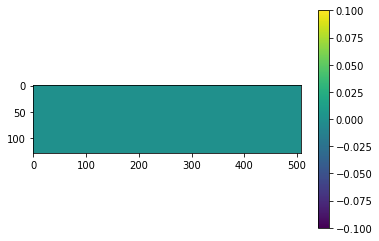

In [192]:

ut = list()
for i in range(0,time,int(time/10))[:-1]:
    print(i)
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['U'][0,2,2:-2,0]/Velocity, label=i)
    ut.append(np.absolute(f['U'][0,0,0,0]))
plt.legend()
    

plt.figure()
from scipy.integrate import odeint

def dydt(y,t,*gamma):
     return gamma[0]*(1-y)
   

y0 = f['PHI'][0,2,6]

t = np.linspace(0,40)
sol = odeint(dydt, y0, t, args=(LinearReactionRate/Velocity,0))


for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    plt.plot(f['PHI'][0,2,6:-2], label=i)
    
plt.plot(t,sol, 'k--', lw=1.5)

plt.legend()


plt.figure()

plt.plot(f['ReactiveFlux'][0,:,2:-2].mean(axis=0), '-', lw=1)
plt.plot(f['ReactiveFlux'][0,:,2:-2].max(axis=0), '-', lw=0.5)
plt.plot(f['ReactiveFlux'][0,:,2:-2].min(axis=0), '-', lw=0.5)

plt.grid()
plt.twinx()
plt.plot(f['Porosity'][0,:,2:-2].min(axis=0), 'r--', lw=0.5)
plt.plot(f['Porosity'][0,:,2:-2].max(axis=0), 'r--', lw=0.5)

plt.figure()

plt.imshow(f['ReactiveFlux'][0,:,2:-2] )
plt.colorbar()

plt.figure()
C = 4*Porosity[:,2:-2]*(1-Porosity[:,2:-2])*LinearReactionRate*(1 - f['PHI'][0,:,2:-2]);
plt.imshow(C*SolidFluidReactionRate > Porosity[:,2:-2])
plt.colorbar()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = './output/Pseudo1DFlow_HDF5_00071680.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

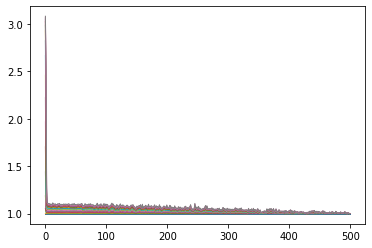

In [193]:
plt.figure()
i = time
f0 = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)  

for i in time+np.arange(0,time1,int(time1/(makroIterations)))[:]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    #plt.plot(f['Porosity'][0,:,6:-6].min(axis=0), '--', lw=0.5)
    #plt.plot(f['Porosity'][0,:,6:-6].max(axis=0), '--', lw=0.5)
    plt.plot((f['Porosity'][0,:,6:-6]/f0['Porosity'][0,:,6:-6]).mean(axis=0), '-', lw=1)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = './output/Pseudo1DFlow_HDF5_00074240.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

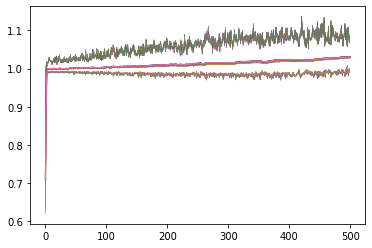

In [194]:
plt.figure()
i = time
f0 = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)  

for i in time+np.arange(0,time1,int(time1/(makroIterations)))[::1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    
    rp = f['PHI'][0,:,6:-6] 
    
    plt.plot(rp.min(axis=0), '--', lw=0.5)
    plt.plot(rp.max(axis=0), '--', lw=0.5)
    plt.plot(rp.mean(axis=0), '-', lw=1)

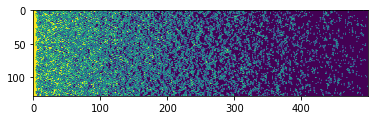

In [203]:
plt.imshow(f['Porosity'][0,:,6:-6]/f0['Porosity'][0,:,6:-6] > 1.1)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = './output/Pseudo1DFlow_HDF5_00384000.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

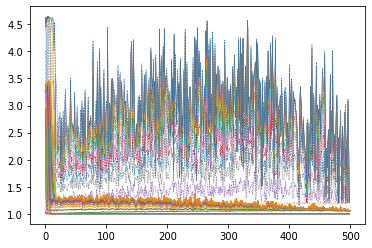

In [213]:
plt.figure()
i = 0
f0 = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)  

for i in time+np.arange(0,time1,int(time1/(makroIterations)))[::10]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    
    rp = f['Porosity'][0,:,6:-6]/f0['Porosity'][0,:,6:-6]
    
    plt.plot(rp.min(axis=0), '--', lw=0.5)
    plt.plot(rp.max(axis=0), '--', lw=0.5)
    plt.plot(rp.mean(axis=0), '-', lw=1)

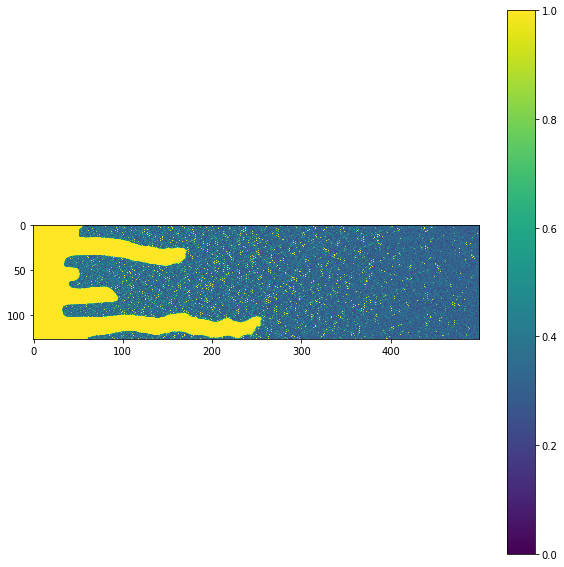

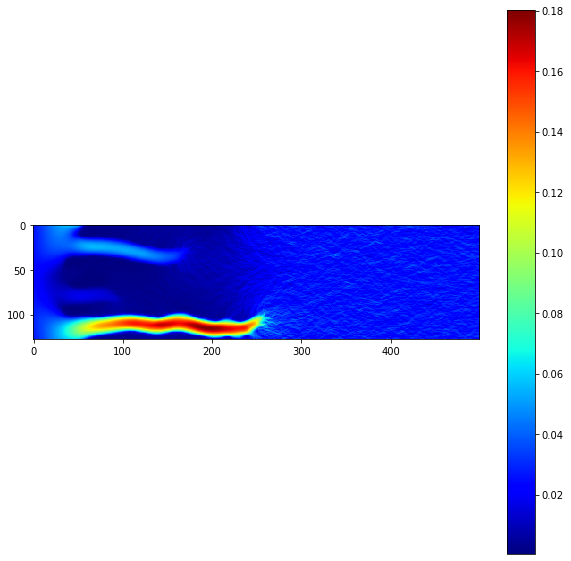

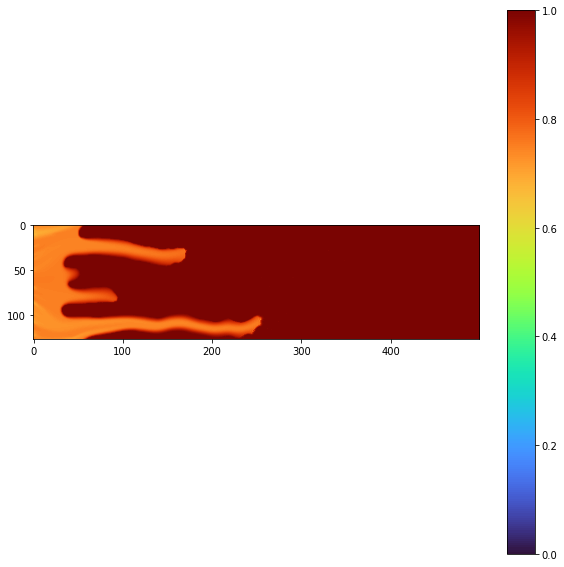

2583040.0


In [223]:
plt.figure(figsize=(10,10))
i = time
f0 = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)  
ii = 1
try:
    for i in time+np.arange(0,time1,int(time1/(makroIterations)))[:]:
        f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
        if np.any(np.isnan(f['Porosity'][0,:,6:-6])): 
            raise Exception()
        ik = i
            
except:
    pass
f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%ik)            
df = f['Porosity'][0,:,6:-6]#/f0['Porosity'][0,:,6:-6] 
plt.imshow(df,interpolation='none')
plt.clim(0,1)
plt.colorbar()
ii = ii + 1


plt.figure(figsize=(10,10))
df = np.sqrt(f['U'][1,:,6:-6,0]**2 + f['U'][1,:,6:-6,1]**2)
plt.imshow(df,interpolation='none',cmap='jet')
#plt.clim(0,1)
plt.colorbar()
ii = ii + 1


plt.figure(figsize=(10,10))
df = f['PHI'][1,:,6:-6]
plt.imshow(df,cmap='turbo')
plt.clim(0,1)
plt.colorbar()
ii = ii + 1

#plt.savefig(r'./movie/wormhole-%03d.png'%ii, dpi=100)
plt.show()    
print(ik)

In [226]:
i = time
f0 = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)  
ii = 1
plt.figure(figsize=(10,10))

try:
    for i in time+np.arange(0,time1,int(time1/(makroIterations)))[::5]:
        f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)    
        if np.any(np.isnan(f['Porosity'][0,:,6:-6])): 
            raise Exception()
        ik = i
            
    
        plt.subplot(131)
        f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%ik)            
        df = f['Porosity'][0,:,6:-6]#/f0['Porosity'][0,:,6:-6] 
        plt.imshow(df.T,interpolation='none')
        plt.clim(0,1)
        plt.colorbar()


        plt.subplot(132)
        df = np.sqrt(f['U'][1,:,6:-6,0]**2 + f['U'][1,:,6:-6,1]**2) / Velocity
        plt.imshow(df.T,interpolation='none',cmap='jet')
        plt.clim(0,5)
        plt.colorbar()


        plt.subplot(133)
        df = f['PHI'][1,:,6:-6]
        plt.imshow(df.T,cmap='turbo')
        plt.clim(0,1)
        plt.colorbar()
        ii = ii + 1
        plt.tight_layout()
        plt.savefig(r'./movie/wormhole-%04d.png'%ii, dpi=100)
        plt.clf()
except:
    pass
        

<Figure size 720x720 with 0 Axes>

In [87]:
i = time
f0 = h5py.File('./output_1/Pseudo1DFlow_HDF5_%08d.h5'%i)  
ii = 1
plt.figure(figsize=(10,10))
Porosity_Evelotion = list()

for i in time+np.arange(0,time1,int(time1/(makroIterations)))[::5]:
    print(i)
    f = h5py.File('./output_1/Pseudo1DFlow_HDF5_%08d.h5'%i)    
    if np.any(np.isnan(f['Porosity'][0,:,6:-6])): 
        raise Exception()
    ik = i           

    f = h5py.File('./output_1/Pseudo1DFlow_HDF5_%08d.h5'%ik)            
    Porosity_Evelotion.append((np.sum(f['Porosity'][0,:,6:-6])))



<ipython-input-87-f1d75ccda81d>:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f0 = h5py.File('./output_1/Pseudo1DFlow_HDF5_%08d.h5'%i)
<ipython-input-87-f1d75ccda81d>:9: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File('./output_1/Pseudo1DFlow_HDF5_%08d.h5'%i)
<ipython-input-87-f1d75ccda81d>:14: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only

25600.0
38400.0
51200.0
64000.0
76800.0
89600.0
102400.0
115200.0
128000.0
140800.0
153600.0
166400.0
179200.0
192000.0
204800.0
217600.0
230400.0
243200.0
256000.0
268800.0
281600.0
294400.0
307200.0
320000.0
332800.0
345600.0
358400.0
371200.0
384000.0
396800.0
409600.0
422400.0
435200.0
448000.0
460800.0
473600.0
486400.0
499200.0
512000.0
524800.0
537600.0
550400.0
563200.0
576000.0
588800.0
601600.0
614400.0
627200.0
640000.0
652800.0
665600.0
678400.0
691200.0
704000.0
716800.0
729600.0
742400.0
755200.0
768000.0
780800.0
793600.0
806400.0
819200.0
832000.0
844800.0
857600.0
870400.0
883200.0
896000.0
908800.0
921600.0
934400.0
947200.0
960000.0
972800.0
985600.0
998400.0
1011200.0
1024000.0
1036800.0
1049600.0
1062400.0
1075200.0
1088000.0
1100800.0
1113600.0
1126400.0
1139200.0
1152000.0
1164800.0
1177600.0
1190400.0
1203200.0
1216000.0
1228800.0
1241600.0
1254400.0
1267200.0
1280000.0
1292800.0
1305600.0
1318400.0
1331200.0
1344000.0
1356800.0
1369600.0
1382400.0
1395200.0
140

<Figure size 720x720 with 0 Axes>

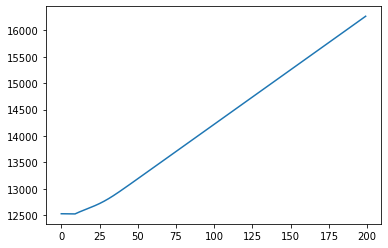

In [89]:
plt.plot(Porosity_Evelotion, '-')